## Cleaning data

## Install libraries

In [3]:
!pip freeze | grep "^datasets" || pip install datasets
!pip freeze | grep "^nltk" || pip install nltk
!pip freeze | grep "^autocorrect " || pip install autocorrect

'grep' is not recognized as an internal or external command,
operable program or batch file.
'grep' is not recognized as an internal or external command,
operable program or batch file.
'grep' is not recognized as an internal or external command,
operable program or batch file.


# Import libraries

In [4]:
import numpy as np
#from google.colab import drive
from datasets import load_dataset
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pandas as pd
from autocorrect import Speller
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re

try:
    nltk.data.find('tokenizers/punkt.zip')
    nltk.data.find('tokenizers/punkt_tab.zip')
    nltk.data.find('corpora/stopwords.zip')
except LookupError:
    nltk.download('punkt')
    nltk.download('punkt_tab')
    nltk.download('stopwords')
    nltk.download('wordnet')

spell = Speller(lang='en')
tfidf = TfidfVectorizer(smooth_idf=True)

c:\Users\rperi\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Functions

In [5]:
def remove_repeating_letters_two(text):
    return re.sub(r'(\w)\1{2,}', r'\1\1', text)

In [6]:
def softmax(x, axis=0):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=axis, keepdims=True)

## Import datasets

In [7]:
# Import all datasets from the McAuley-Lab/Amazon-Reviews-2023 repository

dataset_All_Beauty = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_All_Beauty", trust_remote_code=True)
dataset_Amazon_Fashion = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Amazon_Fashion", trust_remote_code=True)

In [8]:
dataset_All_Beauty_df = dataset_All_Beauty['full'].to_pandas() # Access the 'full' split and call to_pandas()
dataset_Amazon_Fashion_df = dataset_Amazon_Fashion['full'].to_pandas() # Access the 'full' split and call to_pandas()

In [9]:
dataset_All_Beauty_df.head(10)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,0,True
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588615855070,1,True
2,5.0,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,1589665266052,2,True
3,1.0,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1643393630220,0,True
4,5.0,A+,Love it,[],B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1609322563534,0,True
5,4.0,Pretty Color,The polish was quiet thick and did not apply s...,"[{'attachment_type': 'IMAGE', 'large_image_url...",B00R8DXL44,B00R8DXL44,AGMJ3EMDVL6OWBJF7CA5RGJLXN5A,1598567408138,0,True
6,5.0,Handy,Great for many tasks. I purchased these for m...,[],B099DRHW5V,B099DRHW5V,AHREXOGQPZDA6354MHH4ETSF3MCQ,1631885519443,0,True
7,3.0,Meh,These were lightweight and soft but much too s...,"[{'attachment_type': 'IMAGE', 'large_image_url...",B088SZDGXG,B08BBQ29N5,AEYORY2AVPMCPDV57CE337YU5LXA,1634275259292,0,True
8,5.0,Great for at home use and so easy to use!,This is perfect for my between salon visits. I...,[],B08P2DZB4X,B08P2DZB4X,AFSKPY37N3C43SOI5IEXEK5JSIYA,1627391044559,0,False
9,5.0,Nice shampoo for the money,I get Keratin treatments at the salon at least...,[],B086QY6T7N,B086QY6T7N,AFSKPY37N3C43SOI5IEXEK5JSIYA,1626614511145,0,False


In [10]:
# Select the main features and output
beauty_df = dataset_All_Beauty_df[['rating', 'title', 'text', 'parent_asin']]
beauty_df.head(10)

,rating,title,text,parent_asin
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,B00YQ6X8EO
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",B081TJ8YS3
2,5.0,Yes!,"Smells good, feels great!",B097R46CSY
3,1.0,Synthetic feeling,Felt synthetic,B09JS339BZ
4,5.0,A+,Love it,B08BZ63GMJ
5,4.0,Pretty Color,The polish was quiet thick and did not apply s...,B00R8DXL44
6,5.0,Handy,Great for many tasks. I purchased these for m...,B099DRHW5V
7,3.0,Meh,These were lightweight and soft but much too s...,B08BBQ29N5
8,5.0,Great for at home use and so easy to use!,This is perfect for my between salon visits. I...,B08P2DZB4X
9,5.0,Nice shampoo for the money,I get Keratin treatments at the salon at least...,B086QY6T7N


Stopwords, Unir titulo, lowercase, puntuacion, lemmatizacion, missing values, duplicates, embeddings como resultado final

In [11]:
# Join title of review and the review
beauty_df['text'] = beauty_df['title']+' '+beauty_df['text']
beauty_df = beauty_df.drop(columns=['title'])
beauty_df.head(10)

C:\Users\rperi\AppData\Local\Temp\ipykernel_5376\2014830016.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beauty_df['text'] = beauty_df['title']+' '+beauty_df['text']


,rating,text,parent_asin
0,5.0,Such a lovely scent but not overpowering. This...,B00YQ6X8EO
1,4.0,Works great but smells a little weird. This pr...,B081TJ8YS3
2,5.0,"Yes! Smells good, feels great!",B097R46CSY
3,1.0,Synthetic feeling Felt synthetic,B09JS339BZ
4,5.0,A+ Love it,B08BZ63GMJ
5,4.0,Pretty Color The polish was quiet thick and di...,B00R8DXL44
6,5.0,Handy Great for many tasks. I purchased these...,B099DRHW5V
7,3.0,Meh These were lightweight and soft but much t...,B08BBQ29N5
8,5.0,Great for at home use and so easy to use! This...,B08P2DZB4X
9,5.0,Nice shampoo for the money I get Keratin treat...,B086QY6T7N


In [12]:
# Remove the missing values
beauty_df = beauty_df.dropna()
beauty_df.shape, beauty_df.head(10)

((701528, 3),
    rating                                               text parent_asin
 0     5.0  Such a lovely scent but not overpowering. This...  B00YQ6X8EO
 1     4.0  Works great but smells a little weird. This pr...  B081TJ8YS3
 2     5.0                     Yes! Smells good, feels great!  B097R46CSY
 3     1.0                   Synthetic feeling Felt synthetic  B09JS339BZ
 4     5.0                                         A+ Love it  B08BZ63GMJ
 5     4.0  Pretty Color The polish was quiet thick and di...  B00R8DXL44
 6     5.0  Handy Great for many tasks.  I purchased these...  B099DRHW5V
 7     3.0  Meh These were lightweight and soft but much t...  B08BBQ29N5
 8     5.0  Great for at home use and so easy to use! This...  B08P2DZB4X
 9     5.0  Nice shampoo for the money I get Keratin treat...  B086QY6T7N)

## NLP cleaning

In [ ]:
import string

beauty_df.dropna(inplace=True)  # Remove rows with missing values
beauty_df.drop_duplicates(inplace=True)  # Remove duplicate rows
beauty_df.size
# para hacerlo mas rapido (son muchos datos)
sample_size = int(len(beauty_df) * 0.1)
sampled_beauty_df = beauty_df.sample(n=sample_size, random_state=42)  # Use random_state for reproducibility
beauty_df=sampled_beauty_df

stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
lemmatizer = nltk.stem.WordNetLemmatizer()

# Function to eliminate stopwoerds, punctuation and apply lemmatization
def preprocess_text(text):
  text = text.lower()
  tokens = word_tokenize(text)

  # Remove stopwords and punctuation
  filtered_tokens = [token for token in tokens if token.isalnum() and token not in punctuation]

  # Correct words
  remove_repetitions = [remove_repeating_letters_two(word) for word in filtered_tokens]
  corrected_tokens = [spell(word) for word in remove_repetitions]
  corrected_tokens = [word for word in corrected_tokens if word != '']
  filtered_tokens = [word for word in corrected_tokens if word not in stop_words]

  # Apply lemmatization
  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

  # Join the tokens back together
  processed_text = ' '.join(lemmatized_tokens)

  return processed_text

beauty_df['text'] = beauty_df['text'].apply(preprocess_text)

beauty_df.head(10)

,rating,text,parent_asin
357626,5.0,great brush great brush another similar one re...,B01LZY0HO3
381426,3.0,husband hairstyle work ok hobby ton course red...,B07RLY4FTC
415198,5.0,work well man shaving brush could find none be...,B01CBANZKI
151407,2.0,ordered brush cool like ordered brush cool lik...,B01EUAUTCE
53680,5.0,highly recommended item good quality product,B0865H5R1X
594622,5.0,good product asin b005f11wp6 bundle monster 15...,B005F11WP6
330109,4.0,nice product great buy though cheap good quali...,B0799MRQFM
330981,5.0,work intended good warring work well lifting h...,B077FFCS6F
436404,1.0,even worth probably worst hair ever purchased ...,B0758D5NZS
196731,5.0,life saving roller tool found different sized ...,B07FK5ZRPM


In [14]:
output_file_path = "processed_beauty_data.csv"
beauty_df.to_csv(output_file_path, index=False, encoding='utf-8')


## Apply Embedding

In [ ]:
import numpy as np
#from google.colab import drive
from datasets import load_dataset
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pandas as pd
from autocorrect import Speller
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\rperi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [27]:
beauty_df = pd.read_csv('processed_beauty_data.csv')
beauty_df.head(10)

,rating,text,parent_asin
0,5.0,great brush great brush another similar one re...,B01LZY0HO3
1,3.0,husband hairstyle work ok hobby ton course red...,B07RLY4FTC
2,5.0,work well man shaving brush could find none be...,B01CBANZKI
3,2.0,ordered brush cool like ordered brush cool lik...,B01EUAUTCE
4,5.0,highly recommended item good quality product,B0865H5R1X
5,5.0,good product asin b005f11wp6 bundle monster 15...,B005F11WP6
6,4.0,nice product great buy though cheap good quali...,B0799MRQFM
7,5.0,work intended good warring work well lifting h...,B077FFCS6F
8,1.0,even worth probably worst hair ever purchased ...,B0758D5NZS
9,5.0,life saving roller tool found different sized ...,B07FK5ZRPM


In [29]:
# First of all apply and Train Word2Vec model to the dataset
import gensim

# Ensure all values in 'text' column are strings
beauty_df['text'] = beauty_df['text'].astype(str)

# Prepare the corpus for Word2Vec model
corpus = [word_tokenize(review) for review in beauty_df['text'].tolist()]

# Train the Word2Vec model
word2vec_model = gensim.models.Word2Vec(corpus, vector_size=100, window=5, min_count=1, workers=4, seed=1)

# Function to get the average embedding of a review
def get_embedding(text):
    tokens = word_tokenize(text)
    embeddings = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

beauty_df['embedding'] = beauty_df['text'].apply(get_embedding)

beauty_df.head(10)

,rating,text,parent_asin,embedding
0,5.0,great brush great brush another similar one re...,B01LZY0HO3,"[-0.29216182, 0.13105273, -0.11536673, 0.83496..."
1,3.0,husband hairstyle work ok hobby ton course red...,B07RLY4FTC,"[0.007269519, 0.32186738, -0.070532866, 0.7644..."
2,5.0,work well man shaving brush could find none be...,B01CBANZKI,"[0.011906484, -0.12995917, 0.08027631, 0.72330..."
3,2.0,ordered brush cool like ordered brush cool lik...,B01EUAUTCE,"[0.0060083345, 0.42733768, -0.3075137, 0.34734..."
4,5.0,highly recommended item good quality product,B0865H5R1X,"[-0.46857628, -0.13216312, -0.087275185, 0.573..."
5,5.0,good product asin b005f11wp6 bundle monster 15...,B005F11WP6,"[-0.2748698, 0.30751905, -0.22462556, 0.450926..."
6,4.0,nice product great buy though cheap good quali...,B0799MRQFM,"[-0.22014499, 0.009579052, -0.069985524, 1.005..."
7,5.0,work intended good warring work well lifting h...,B077FFCS6F,"[-0.08705119, 0.44075882, 0.1529369, 0.7068301..."
8,1.0,even worth probably worst hair ever purchased ...,B0758D5NZS,"[-0.18917641, 0.15138052, -0.25625843, 0.26356..."
9,5.0,life saving roller tool found different sized ...,B07FK5ZRPM,"[-0.09847134, -0.11704393, -0.3043593, 0.37563..."


# Train a RNN to predict the star rating of a review


In [30]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score

# Assuming beauty_df has 'embedding' and 'rating' columns
X = np.array(beauty_df['embedding'].tolist())
y = np.array(beauty_df['rating'].tolist())

# Reshape X to be 3D [samples, timesteps, features] if necessary
X = X.reshape((X.shape[0], 1, X.shape[1]))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the RNN model with more regularization
model = Sequential()
model.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(32, activation='tanh', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(16, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='linear'))  # Assuming ratings are continuous values

# Print the model summary
model.summary()

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

# Define early stopping callback
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


c:\Users\rperi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 1, 128)         │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 1, 32)          │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,241 (422.82 KB)

 Trainable params: 108,241 (422.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 3.3823 - mae: 1.3678 - val_loss: 0.8717 - val_mae: 0.6413
Epoch 2/50
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.2544 - mae: 0.8547 - val_loss: 0.8313 - val_mae: 0.6176
Epoch 3/50
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.1342 - mae: 0.8072 - val_loss: 0.8216 - val_mae: 0.6105
Epoch 4/50
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.0536 - mae: 0.7667 - val_loss: 0.7960 - val_mae: 0.5845
Epoch 5/50
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.9692 - mae: 0.7236 - val_loss: 0.7967 - val_mae: 0.5969
Epoch 6/50
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.9288 - mae: 0.7029 - val_loss: 0.7770 - val_mae: 0.5671
Epoch 7/50
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.8870 - mae: 0.6742 - val_loss: 0.7857 - val_mae: 0.5780
Epoch 8/50
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.8494 - mae: 0.6528 - val_loss: 0.7721 - val_mae: 0.5530
Epoch 9/50
1735/1735 ━━━━━━━━━━━━━━━━━━━

434/434 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - loss: 0.7850 - mae: 0.5539
Test Loss: 0.781978189945221
Test MAE: 0.5504065155982971
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


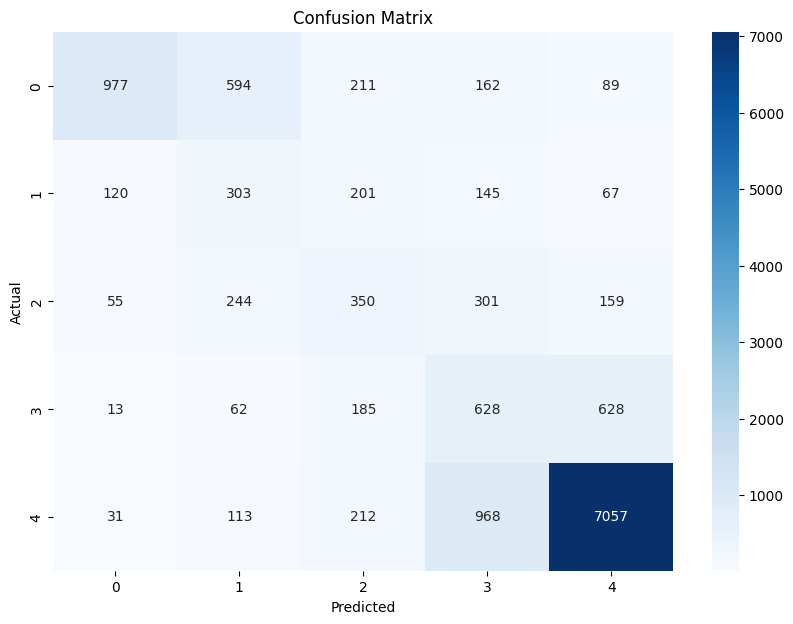

Precision: 0.7216701988208426
Accuracy: 0.6713513513513514
Recall: 0.6713513513513514
F1 Score: 0.6876354492571769


In [31]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test MAE: {mae}')

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred.round())

# Calculate precision, accuracy, recall, and F1 score
precision = precision_score(y_test, y_pred.round(), average='weighted')
accuracy = accuracy_score(y_test, y_pred.round())
recall = recall_score(y_test, y_pred.round(), average='weighted')
f1 = f1_score(y_test, y_pred.round(), average='weighted')

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Precision:", precision)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)